# Capstone Project Part 5: Baseline Models Pre-Tokenizing

**Authur:** Kate Meredith 

**Date:** September-November 2022

**Notebook #**: 5 of

## Background

**Source:** Data was collected from [CoffeeReview.com](https://www.coffeereview.com/) and grouped into two DataFrames for cleaning. See prior notebooks for details on scraping, cleaning and compilation.

**Goal:** Run initial models using numeric data that does not require tokenizing as a baseline.

## References

In [1]:
#Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

### Importing Data and EDA

In [2]:
#importing data
coffee = pd.read_csv('coffee.csv')

In [3]:
#overview of df
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6557 entries, 0 to 6556
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   coffee_name    6557 non-null   object 
 1   roaster_name   6557 non-null   object 
 2   month          6557 non-null   int64  
 3   year           6557 non-null   int64  
 4   bean_agtron    6557 non-null   int64  
 5   ground_agtron  6557 non-null   int64  
 6   aroma          6557 non-null   int64  
 7   acidity        6557 non-null   int64  
 8   body           6557 non-null   int64  
 9   flavor         6557 non-null   int64  
 10  aftertaste     6557 non-null   int64  
 11  roaster_lat    6557 non-null   float64
 12  roaster_lon    6557 non-null   float64
 13  origin_lat     6557 non-null   float64
 14  origin_lon     6557 non-null   float64
 15  p1             6557 non-null   object 
 16  p2             6557 non-null   object 
 17  p3             6557 non-null   object 
 18  overall_

In [4]:
#checking nan
coffee.isnull().sum()

coffee_name      0
roaster_name     0
month            0
year             0
bean_agtron      0
ground_agtron    0
aroma            0
acidity          0
body             0
flavor           0
aftertaste       0
roaster_lat      0
roaster_lon      0
origin_lat       0
origin_lon       0
p1               0
p2               0
p3               0
overall_score    0
dtype: int64

Creating numeric only df to run initial model from:

In [5]:
numeric_df = coffee.filter(['month','year','bean_agtron','ground_agtron','aroma','acidity','body','flavor','aftertaste','roaster_lat','roaster_lon','origin_lat','origin_lon','overall_score'], axis = 1)

In [6]:
#previewing numeric dataframe
numeric_df.head()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,overall_score
0,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813,94
1,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851,94
2,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813,93
3,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691,92
4,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120,93


Plotting numeric value histograms to get sense of distribution. Code based on clustering codealong.

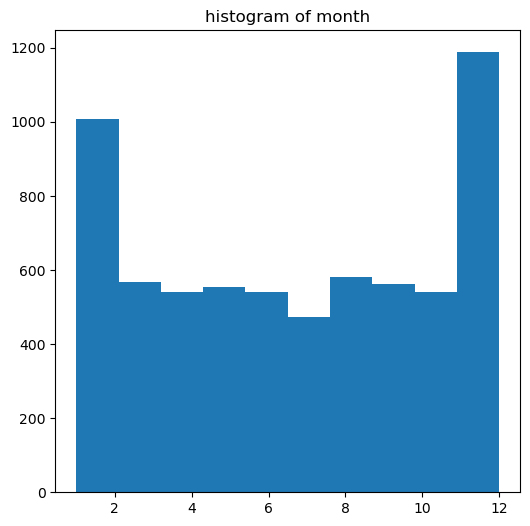

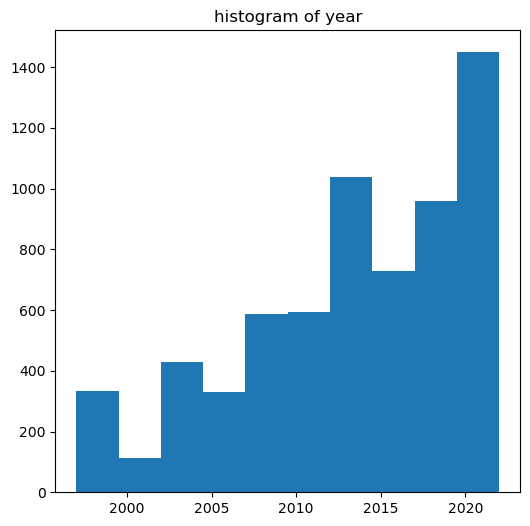

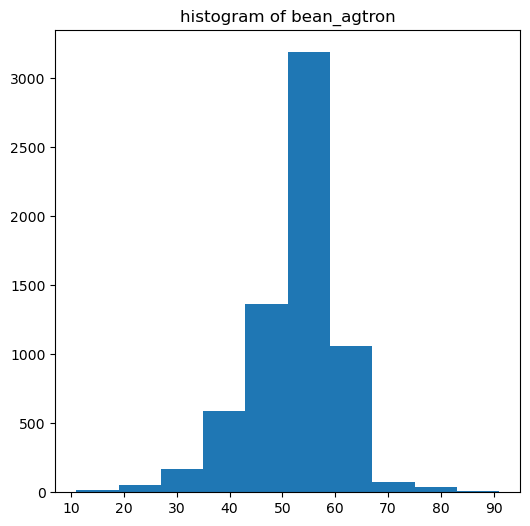

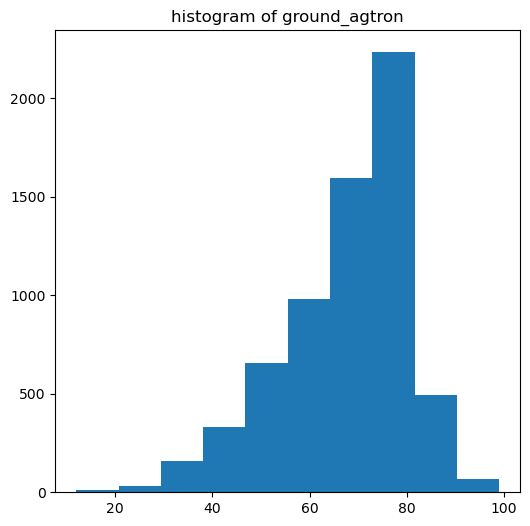

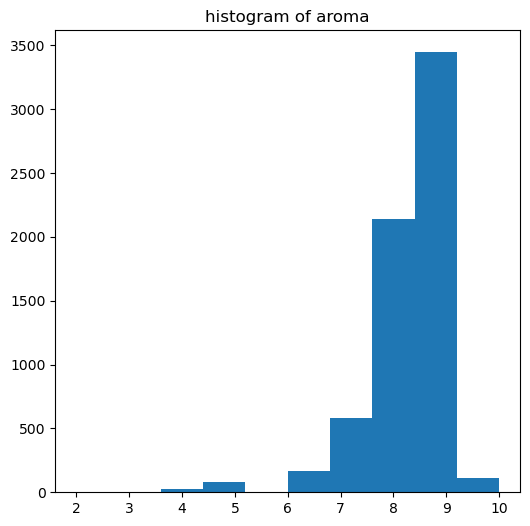

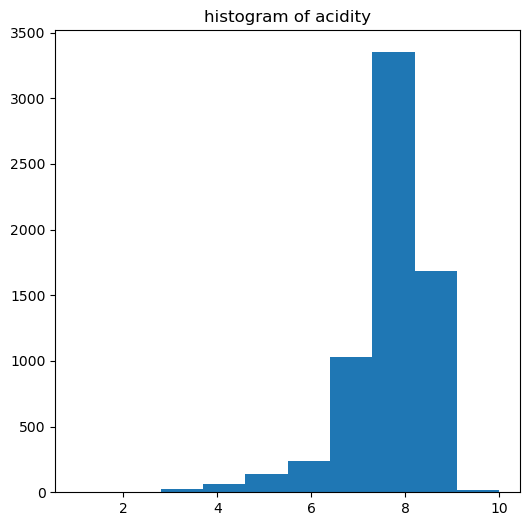

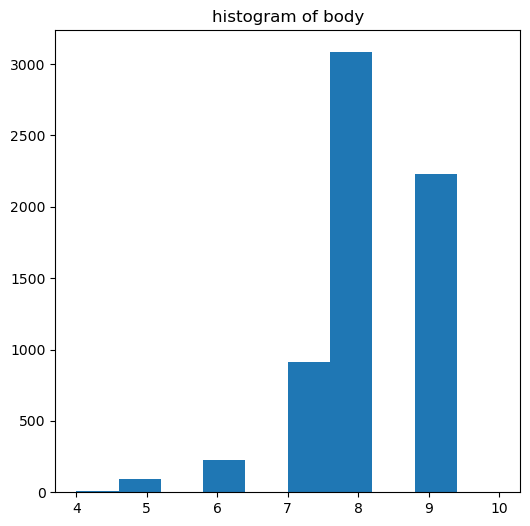

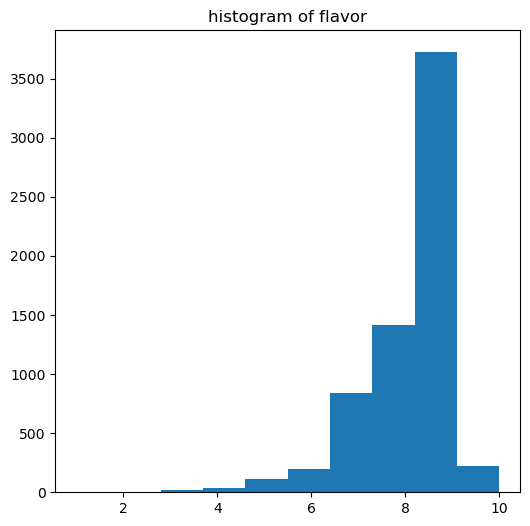

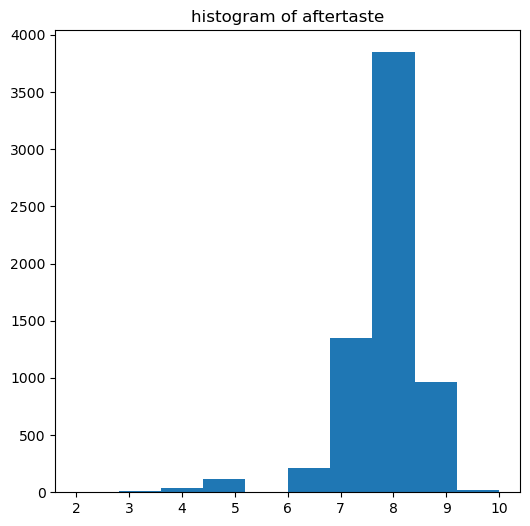

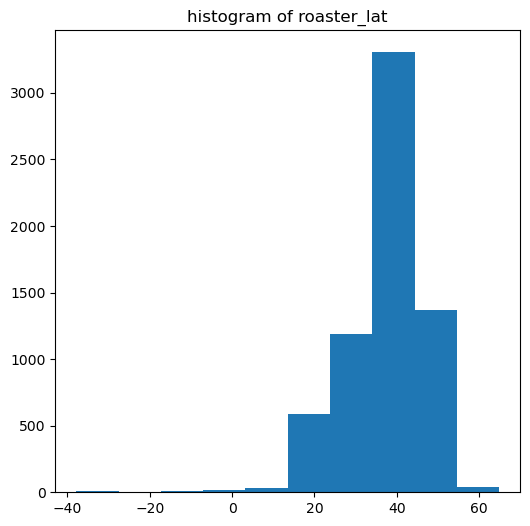

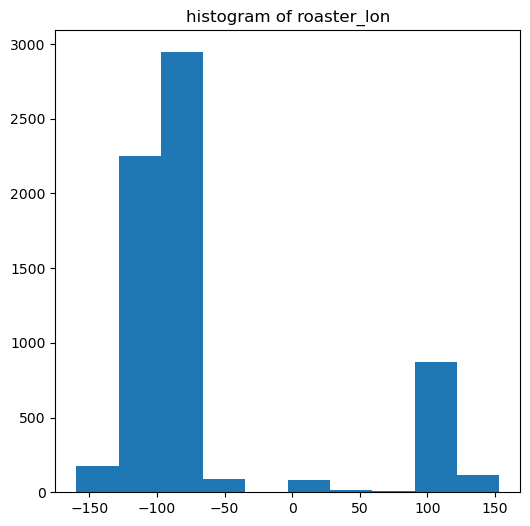

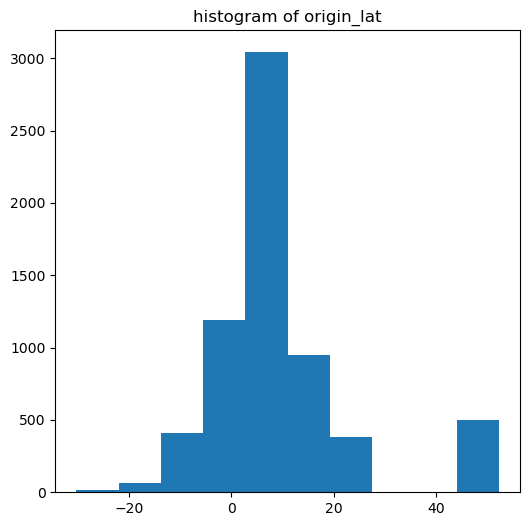

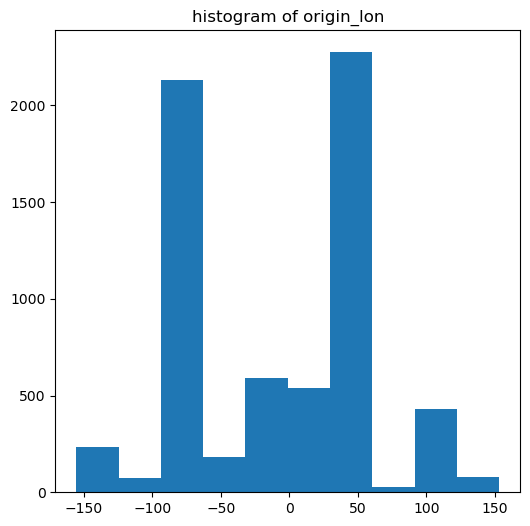

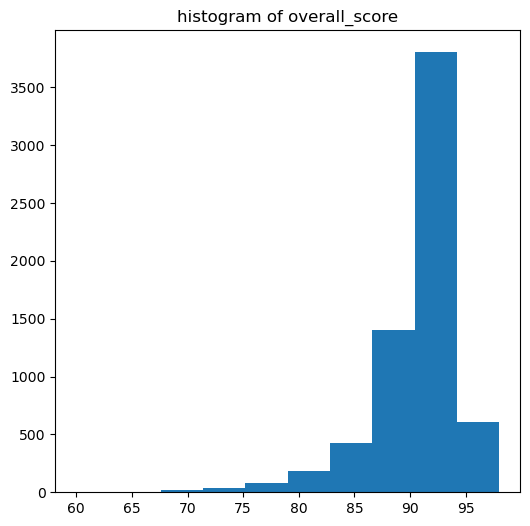

In [7]:
for column in numeric_df.columns:

    plt.figure(figsize = (6,6))
    plt.hist(numeric_df[column])
    plt.title(f"histogram of {column}")
    plt.show()

Commentary on histograms:
- Review month span course of year with spikes in Jan and December
- Number of reviews generally increased year to year
- `bean_agtron` is normally distributed with high number of values between 50 and 60
- `ground_agtron` values are slightly higher on average, with the largest group between 70 and 80
- Subscores for `aroma`, `acidity`, `body`, `flavor`, and `aftertaste` tend to be in higher end of range 0-10
- roasters tend to be in the northern and western hemishere
- coffee tends to originate from the close to the equator in both the western and eastern hemispheres
- `overall_score` (target) tends to be on high end of range 60-100, with most falliing between 90 and 95

Establishing features and target. Target is `overall_score`.

In [8]:
X = numeric_df.drop('overall_score', axis = 1)

In [9]:
X.shape

(6557, 13)

In [10]:
X.head()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon
0,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813
1,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851
2,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813
3,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691
4,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120


In [11]:
y = numeric_df['overall_score']

In [12]:
y.shape

(6557,)

In [13]:
#check out target value overview
y.describe()

count    6557.000000
mean       90.873723
std         4.089739
min        60.000000
25%        90.000000
50%        92.000000
75%        93.000000
max        98.000000
Name: overall_score, dtype: float64

Creating train, validate, test splits.

In [14]:
#create train/test split, using 20% given dataset size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
#create train/validate split, using 20% given dataset size

X_remain, X_val, y_remain, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [16]:
#checking out proportions
X_train.shape

(5245, 13)

In [17]:
X_remain.shape

(4196, 13)

In [18]:
X_test.shape

(1312, 13)

In [19]:
X_val.shape

(1049, 13)

In [20]:
y_remain.shape

(4196,)

In [21]:
y_val.shape

(1049,)

In [22]:
y_test.shape

(1312,)

Scaling data (not always essential for linear regression but do know data is on different scales). Testing both MinMax and StandardScaler. We expect MinMax to be the better fit to adjust for distribution of data.

In [23]:
#standard scaling

s_scaler = StandardScaler()
s_scaler.fit(X_remain)
X_s_scaled_remain = s_scaler.transform(X_remain)
X_s_scaled_val = s_scaler.transform(X_val)
X_s_scaled_test = s_scaler.transform(X_test)

In [24]:
#min max scaling

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_remain)
X_mm_scaled_remain = mm_scaler.transform(X_remain)
X_mm_scaled_val = mm_scaler.transform(X_val)
X_mm_scaled_test = mm_scaler.transform(X_test)

### Model 1: Linear Regression with Standard Scaler

First vanilla model using standard scaler fit on X_scaled_remain.

In [25]:
# 1. Instantiate the model
lr_model_1 = LinearRegression()

# 2. Fit the model
lr_model_1.fit(X_s_scaled_remain, y_remain)

LinearRegression()

Evaluating lr_model_1, uses standard scaler:

In [26]:
# 3. Scoring the models
print(f'The accuracy score for training data is: {lr_model_1.score(X_s_scaled_remain, y_remain)}')

print(f'The accuracy score for validation data is: {lr_model_1.score(X_s_scaled_val, y_val)}')

The accuracy score for training data is: 0.9015722342836519
The accuracy score for validation data is: 0.8974331695791644


Evaluating validation data:

In [27]:
# 1. Instantiate the model
lr_model_2 = LinearRegression()

# 2. Fit the model
lr_model_2.fit(X_mm_scaled_remain, y_remain)

LinearRegression()

In [28]:
# 3. Scoring the models
print(f'The accuracy score for training data is: {lr_model_2.score(X_mm_scaled_remain, y_remain)}')

print(f'The accuracy score for validation data is: {lr_model_2.score(X_mm_scaled_val, y_val)}')

The accuracy score for training data is: 0.9015722342836519
The accuracy score for validation data is: 0.8974331695791644


Comparing to non-scaled data:

In [29]:
# 1. Instantiate the model
lr_model_3 = LinearRegression()

# 2. Fit the model
lr_model_3.fit(X_remain, y_remain)

LinearRegression()

In [30]:
# 3. Scoring the models
print(f'The accuracy score for training data is: {lr_model_3.score(X_remain, y_remain)}')

print(f'The accuracy score for validation data is: {lr_model_3.score(X_val, y_val)}')

The accuracy score for training data is: 0.9015722342836517
The accuracy score for validation data is: 0.8974331695791647


Scaling does not seem to have much impact on our linear regression results. Our baseline linear regression model does a fairly good job predicting the results. 

Exploring correlation of variables:

In [31]:
corr_df = coffee.corr()

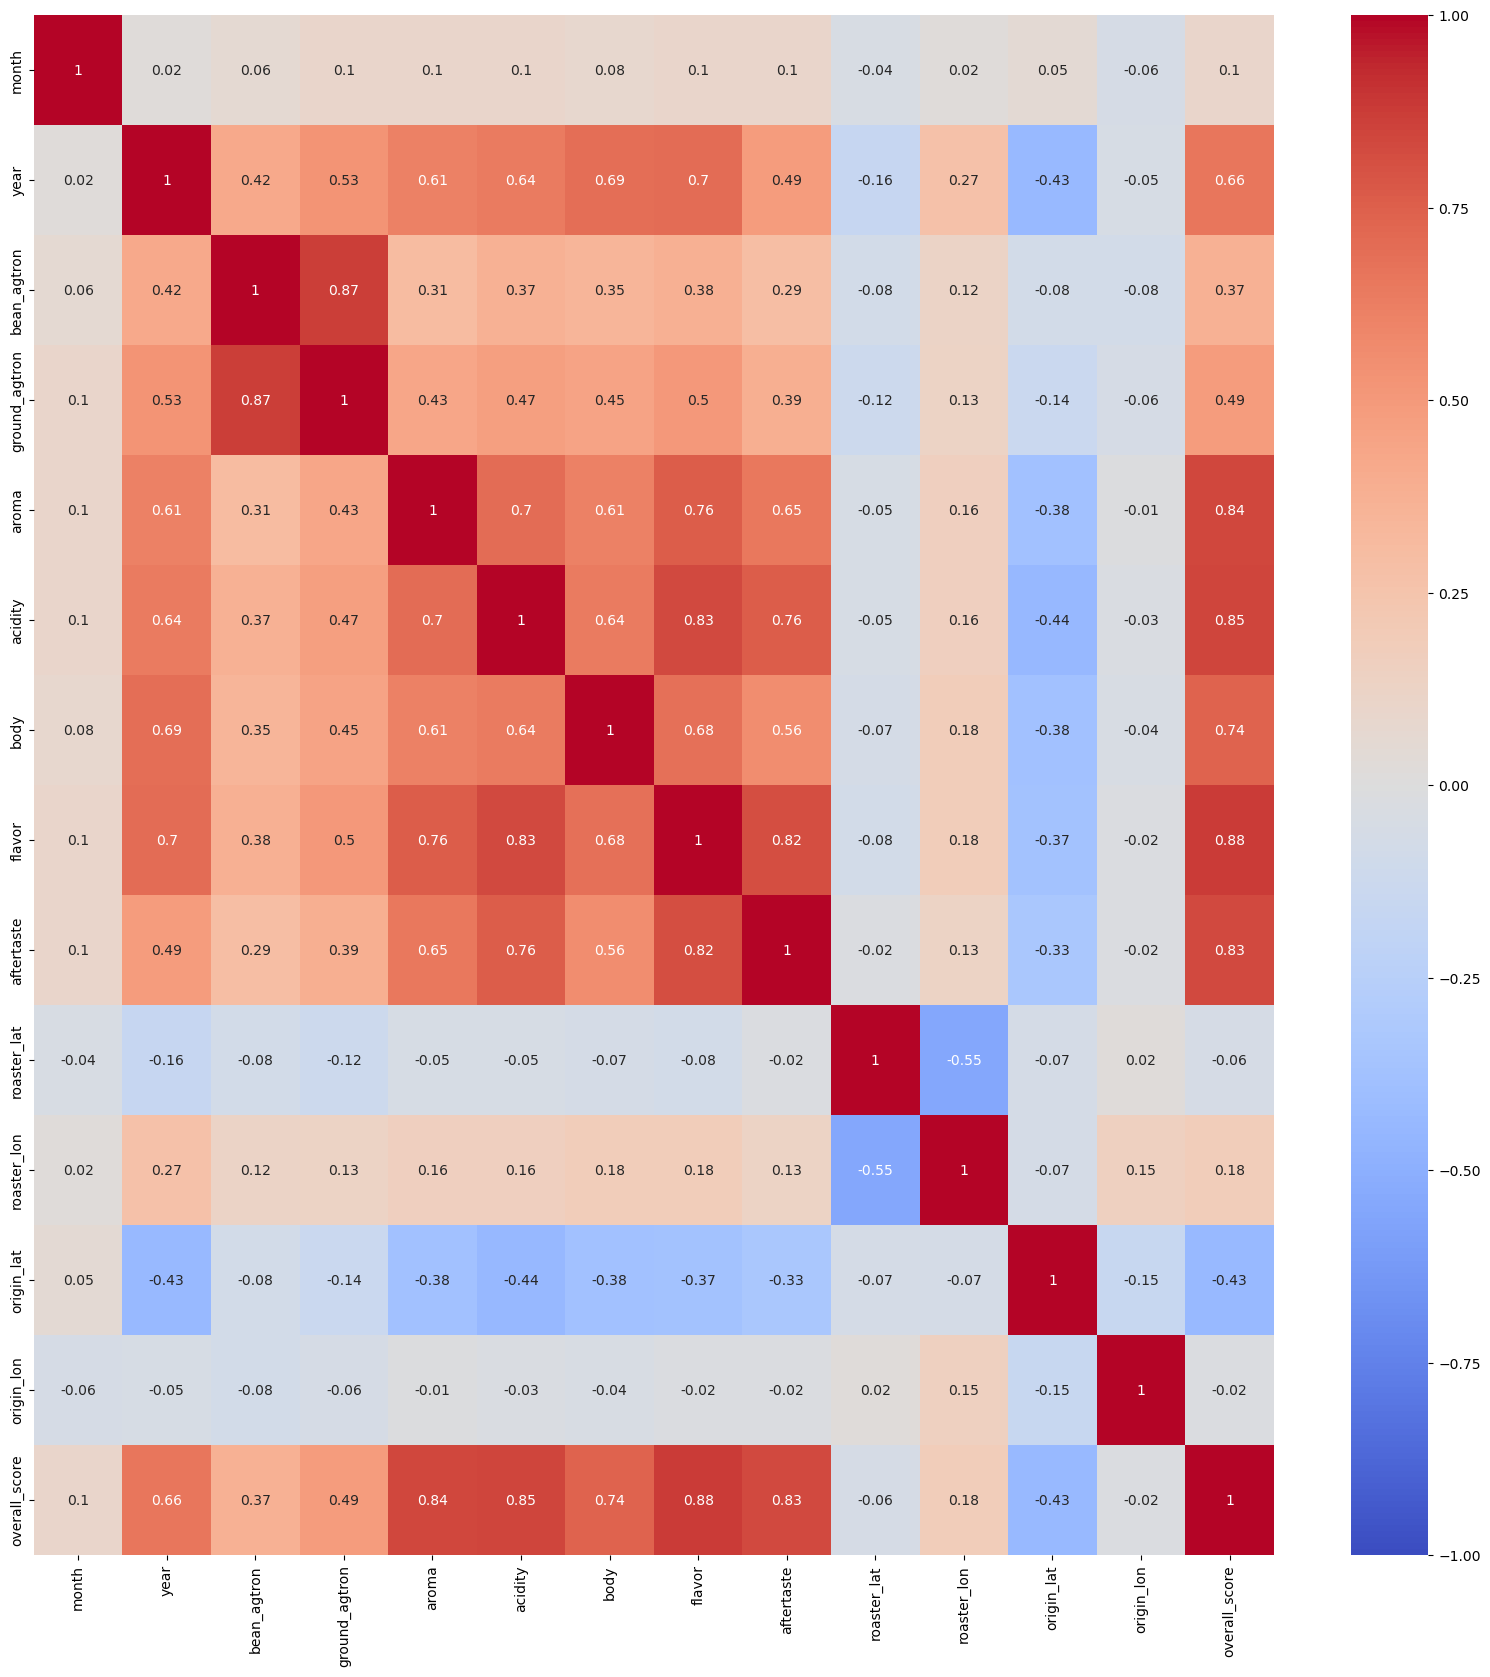

In [32]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), vmax = 1, vmin = -1, center=0, cmap="coolwarm",annot=True)
plt.show()